In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from glob import glob

In [36]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

In [12]:
# run this cell only if the system has Nvidia GPU and CUDA, cuDNN installed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs available:  0


IndexError: list index out of range

In [37]:
disease_types = ['Bacterial_spot','Black_mold','Early_blight','Healthy','Late_blight','Mosaic_virus','Septoria_spot']
data_dir = 'D:/Tomato PDD/ICT4SD4/data2/'
train_dir = os.path.join(data_dir)

In [38]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
#train.tail()
train.head()

,File,DiseaseID,Disease Type
0,Bacterial_spot/BS (1).jpg,0,Bacterial_spot
1,Bacterial_spot/BS (10).jpg,0,Bacterial_spot
2,Bacterial_spot/BS (100).jpg,0,Bacterial_spot
3,Bacterial_spot/BS (101).jpg,0,Bacterial_spot
4,Bacterial_spot/BS (102).jpg,0,Bacterial_spot


In [40]:
SEED = 12
train = train.sample(frac=1, random_state = SEED) 
train.index = np.arange(len(train))
train.head()

,File,DiseaseID,Disease Type
0,Black_mold/BM (172).jpg,1,Black_mold
1,Mosaic_virus/MV (54).jpg,5,Mosaic_virus
2,Early_blight/EB (223).jpg,2,Early_blight
3,Early_blight/EB (51).jpg,2,Early_blight
4,Healthy/THL (80).jpg,3,Healthy


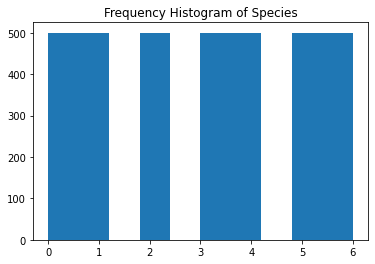

<Figure size 864x864 with 0 Axes>

In [41]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

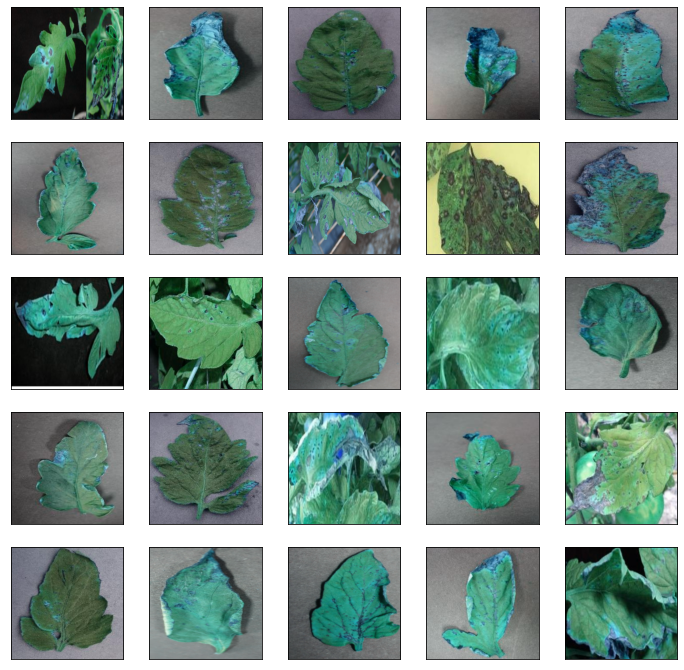

In [42]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Bacterial_spot', 5, 5)

In [43]:
IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [44]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

3498it [00:34, 102.33it/s]


Train Shape: (3498, 224, 224, 3)


In [45]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=7)

In [46]:
BATCH_SIZE = 32

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

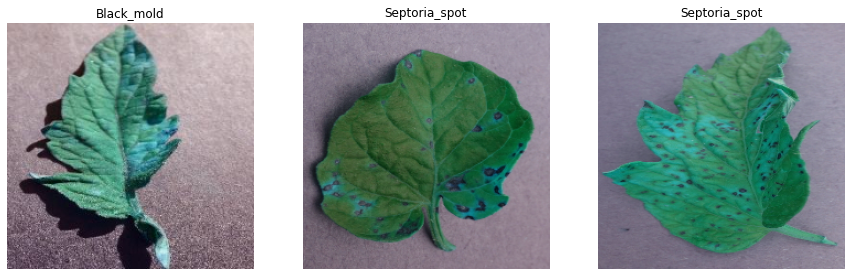

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [48]:
EPOCHS = 10
SIZE = 224
IMAGE_SIZE = [224, 224]
N_ch = 3
folders = glob('D:/Tomato PDD/ICT4SD4/data2/*')
folders

['D:/Tomato PDD/ICT4SD4/data2\\Bacterial_spot',
 'D:/Tomato PDD/ICT4SD4/data2\\Black_mold',
 'D:/Tomato PDD/ICT4SD4/data2\\Early_blight',
 'D:/Tomato PDD/ICT4SD4/data2\\Healthy',
 'D:/Tomato PDD/ICT4SD4/data2\\Late_blight',
 'D:/Tomato PDD/ICT4SD4/data2\\Mosaic_virus',
 'D:/Tomato PDD/ICT4SD4/data2\\Septoria_spot']

In [50]:
vgg16 = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False
    
x = Flatten()(vgg16.output)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [51]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [52]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/10
87/87 - 65s - loss: 4.7033 - accuracy: 0.5484 - val_loss: 3.4476 - val_accuracy: 0.6700

Epoch 00001: val_loss improved from inf to 3.44757, saving model to model.h5


C:\Users\Kartik\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
87/87 - 57s - loss: 3.6036 - accuracy: 0.6659 - val_loss: 3.3617 - val_accuracy: 0.7114

Epoch 00002: val_loss improved from 3.44757 to 3.36167, saving model to model.h5
Epoch 3/10
87/87 - 57s - loss: 3.9272 - accuracy: 0.6681 - val_loss: 3.4706 - val_accuracy: 0.7300

Epoch 00003: val_loss did not improve from 3.36167
Epoch 4/10
87/87 - 58s - loss: 3.5748 - accuracy: 0.7252 - val_loss: 4.2586 - val_accuracy: 0.7300

Epoch 00004: val_loss did not improve from 3.36167
Epoch 5/10
87/87 - 65s - loss: 3.6735 - accuracy: 0.7137 - val_loss: 3.4478 - val_accuracy: 0.7471

Epoch 00005: val_loss did not improve from 3.36167
Epoch 6/10
87/87 - 59s - loss: 3.5948 - accuracy: 0.7346 - val_loss: 3.2680 - val_accuracy: 0.7871

Epoch 00006: val_loss improved from 3.36167 to 3.26796, saving model to model.h5
Epoch 7/10
87/87 - 59s - loss: 3.8177 - accuracy: 0.7448 - val_loss: 4.6082 - val_accuracy: 0.7129

Epoch 00007: val_loss did not improve from 3.26796
Epoch 8/10
87/87 - 60s - loss: 3.8

In [29]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

22/22 [==============================] - 11s 518ms/step - loss: 5.3937 - accuracy: 0.7100
Final Loss: 5.39374303817749, Final Accuracy: 0.7099999785423279


Text(0.5, 144.41374999999996, 'Predicted')

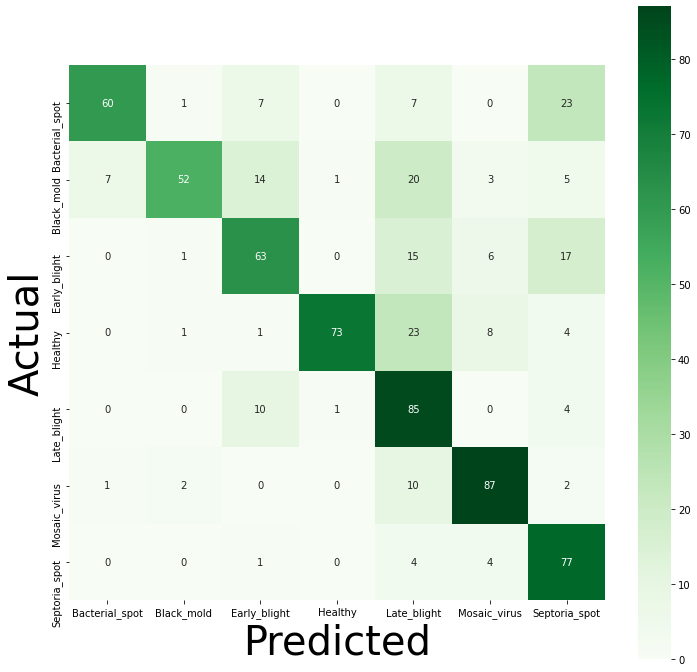

In [30]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

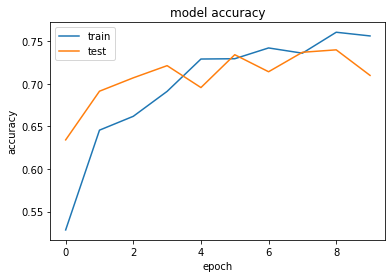

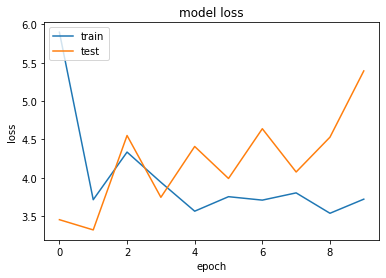

In [31]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
from skimage import io
from keras.preprocessing import image
import time

def main():    
    #path='imbalanced/Scratch/Scratch_400.jpg'
    img = image.load_img('D:/Tomato PDD/ICT4SD4/data3/test/Early_blight/TEB (5).jpg', grayscale=False, target_size=(224, 224))
    show_img=image.load_img('D:/Tomato PDD/ICT4SD4/data3/test/Early_blight/TEB (5).jpg', grayscale=False, target_size=(200, 200))
    disease_class = ['Bacterial_spot','Black_mold','Early_blight','Healthy','Late_blight','Mosaic_virus','Septoria_spot']
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    #x = np.array(x, 'float32')
    x /= 255

    custom = model.predict(x)
    print(custom[0])

    #x = x.reshape([64, 64]);

    #plt.gray()
    plt.imshow(show_img)
    plt.show()

    a=custom[0]
    ind=np.argmax(a)

    print('Prediction:',disease_class[ind])
    return

start_time = time.time()
main()
print("--- %s seconds ---" % (time.time() - start_time))

ModuleNotFoundError: No module named 'skimage'